# Antibody Response Pulse
https://github.com/blab/antibody-response-pulse

### B-cells evolution --- cross-reactive antibody response after influenza virus infection or vaccination
### Adaptive immune response for sequential vaccination

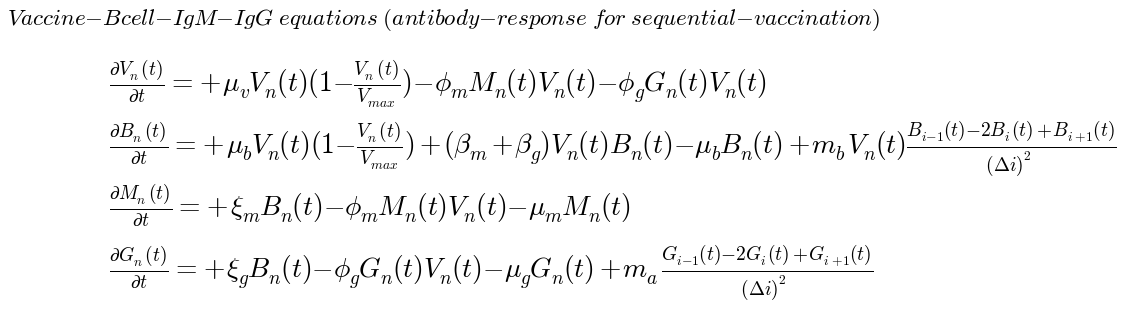

In [1]:
'''
author: Alvason Zhenhua Li
date:   04/09/2015
'''
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib.ticker import FuncFormatter

import alva_machinery_event_bcell as alva

AlvaFontSize = 23
AlvaFigSize = (15, 5)
numberingFig = 0

# plotting
dir_path = '/Users/al/Desktop/GitHub/antibody-response-pulse/bcell-array/figure'
file_name = 'Vaccine-Bcell-IgM-IgG'
figure_name = '-equation'
file_suffix = '.png'
save_figure = os.path.join(dir_path, file_name + figure_name + file_suffix)

numberingFig = numberingFig + 1
plt.figure(numberingFig, figsize=(12, 5))
plt.axis('off')
plt.title(r'$ Vaccine-Bcell-IgM-IgG \ equations \ (antibody-response \ for \ sequential-vaccination) $'
          , fontsize = AlvaFontSize)
plt.text(0, 7.0/9, r'$ \frac{\partial V_n(t)}{\partial t} = \
         +\mu_{v}V_{n}(t)(1 - \frac{V_n(t)}{V_{max}}) - \phi_{m} M_{n}(t) V_{n}(t) - \phi_{g} G_{n}(t) V_{n}(t) $'
         , fontsize = 1.2*AlvaFontSize)
plt.text(0, 5.0/9, r'$ \frac{\partial B_n(t)}{\partial t} = \
         +\mu_{b}V_{n}(t)(1 - \frac{V_n(t)}{V_{max}}) + (\beta_{m} + \beta_{g}) V_{n}(t) B_{n}(t) - \mu_{b} B_{n}(t) \
         + m_b V_{n}(t)\frac{B_{i-1}(t) - 2B_i(t) + B_{i+1}(t)}{(\Delta i)^2} $'
         , fontsize = 1.2*AlvaFontSize)
plt.text(0, 3.0/9,r'$ \frac{\partial M_n(t)}{\partial t} = \
         +\xi_{m} B_{n}(t) - \phi_{m} M_{n}(t) V_{n}(t) - \mu_{m} M_{n}(t) $'
         , fontsize = 1.2*AlvaFontSize)
plt.text(0, 1.0/9,r'$ \frac{\partial G_n(t)}{\partial t} = \
         +\xi_{g} B_{n}(t) - \phi_{g} G_{n}(t) V_{n}(t) - \mu_{g} G_{n}(t) \
         + m_a \frac{G_{i-1}(t) - 2G_i(t) + G_{i+1}(t)}{(\Delta i)^2} $'         
         , fontsize = 1.2*AlvaFontSize)

plt.savefig(save_figure, dpi = 100)
plt.show()

# define the V-B-M-G partial differential equations
def dVdt_array(VBMGxt = [], *args):
    # naming
    V = VBMGxt[0]
    B = VBMGxt[1]
    M = VBMGxt[2]
    G = VBMGxt[3]
    x_totalPoint = VBMGxt.shape[1]
    # there are n dSdt
    dV_dt_array = np.zeros(x_totalPoint)
    # each dSdt with the same equation form
    dV_dt_array[:] = +inRateV*V[:]*(1 - V[:]/maxV) - killRateVm*M[:]*V[:] - killRateVg*G[:]*V[:]
    return(dV_dt_array)

def dBdt_array(VBMGxt = [], *args):
    # naming
    V = VBMGxt[0]
    B = VBMGxt[1]
    M = VBMGxt[2]
    G = VBMGxt[3]
    x_totalPoint = VBMGxt.shape[1]
    # there are n dSdt
    dB_dt_array = np.zeros(x_totalPoint)
    # each dSdt with the same equation form
    Bcopy = np.copy(B)
    centerX = Bcopy[:]
    leftX = np.roll(Bcopy[:], 1)
    rightX = np.roll(Bcopy[:], -1)
    leftX[0] = centerX[0]
    rightX[-1] = centerX[-1]
    dB_dt_array[:] = +inRateB*V[:]*(1 - V[:]/maxV) \
                     + (actRateBm + actRateBg \
                        + alva.event_recovered + alva.event_OAS_press \
                        + alva.event_recoveredV + alva.event_OAS_pressV)*V[:]*B[:] \
                     - (outRateB + alva.event_OAS_slowV)*B[:] \
                     + mutatRateB*V[:]*(leftX[:] - 2*centerX[:] + rightX[:])/(dx**2)
    return(dB_dt_array)

def dMdt_array(VBMGxt = [], *args):
    # naming
    V = VBMGxt[0]
    B = VBMGxt[1]
    M = VBMGxt[2]
    G = VBMGxt[3]
    x_totalPoint = VBMGxt.shape[1]
    # there are n dSdt
    dM_dt_array = np.zeros(x_totalPoint)
    # each dSdt with the same equation form
    dM_dt_array[:] = +inRateM*B[:] - consumeRateM*M[:]*V[:] - outRateM*M[:]
    return(dM_dt_array)

def dGdt_array(VBMGxt = [], *args):
    # naming
    V = VBMGxt[0]
    B = VBMGxt[1]
    M = VBMGxt[2]
    G = VBMGxt[3]
    x_totalPoint = VBMGxt.shape[1]
    # there are n dSdt
    dG_dt_array = np.zeros(x_totalPoint)
    # each dSdt with the same equation form
    Gcopy = np.copy(G)
    centerX = Gcopy[:]
    leftX = np.roll(Gcopy[:], 1)
    rightX = np.roll(Gcopy[:], -1)
    leftX[0] = centerX[0]
    rightX[-1] = centerX[-1]
    dG_dt_array[:] = +(inRateG + alva.event_OAS_boost + alva.event_OAS_boostV)*B[:] \
                     - consumeRateG*G[:]*V[:] - outRateG*G[:] \
                     + mutatRateA*(leftX[:] - 2*centerX[:] + rightX[:])/(dx**2)
    return(dG_dt_array)

event_infect = [[ 0.          0.        ]
 [ 0.          0.92054795]
 [ 0.          1.84109589]
 [ 0.          2.76164384]
 [ 0.          3.68219178]
 [ 0.          4.60273973]
 [ 0.          5.52328767]
 [ 0.          6.44383562]
 [ 0.          7.36438356]
 [ 0.          8.28493151]]
event_repeated = [[ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]]
event_vaccine = [[ 0.          0.        ]
 [ 0.          0.92054795]
 [ 8.          1.84109589]
 [ 8.          2.76164384]
 [ 8.          3.68219178]
 [ 8.          4.60273973]
 [ 8.          5.52328767]
 [ 0.          6.44383562]
 [ 0.          7.36438356]
 [ 0.          8.28493151]]


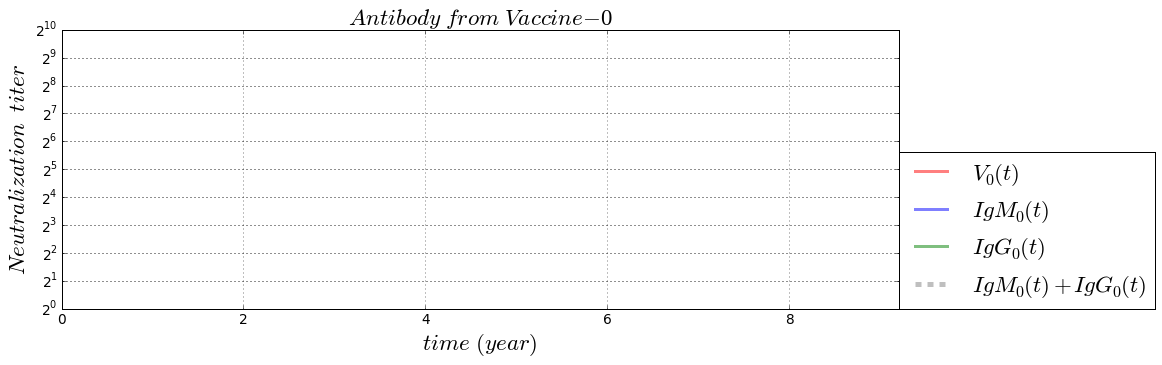

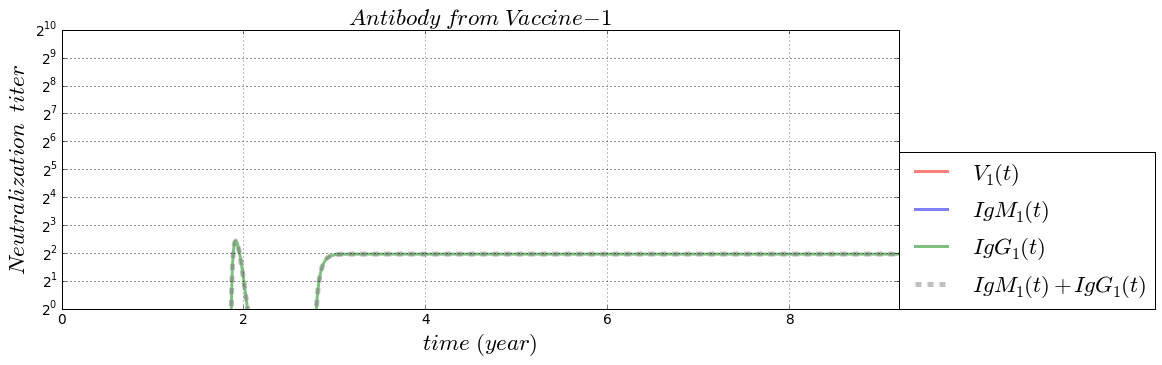

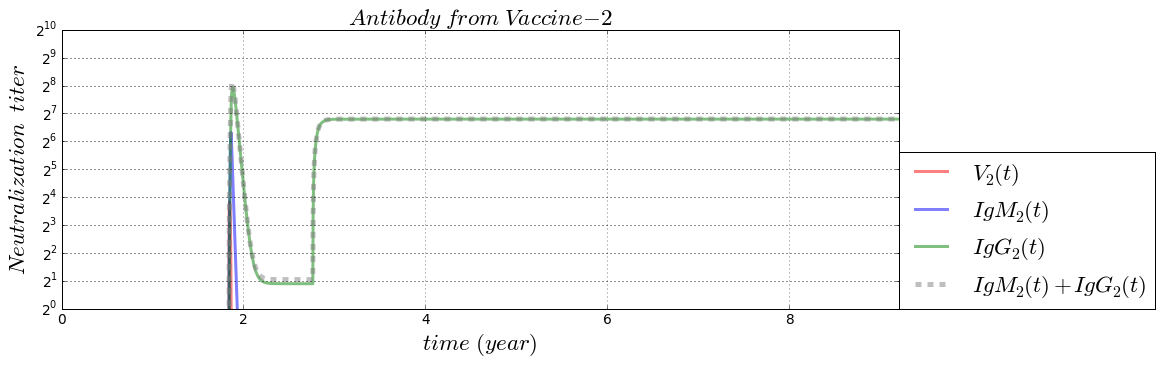

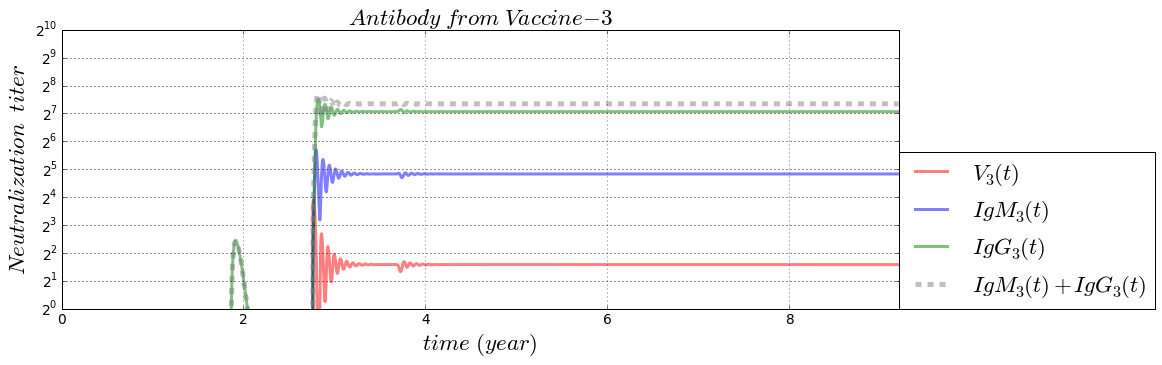

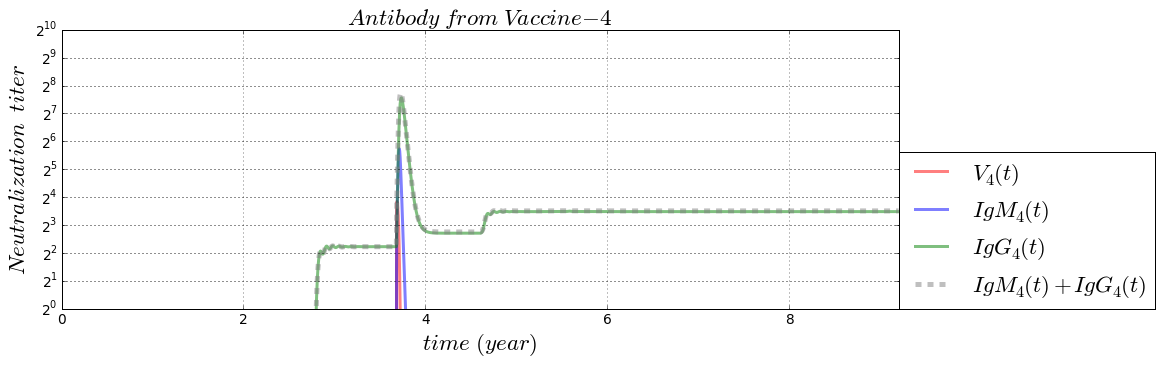

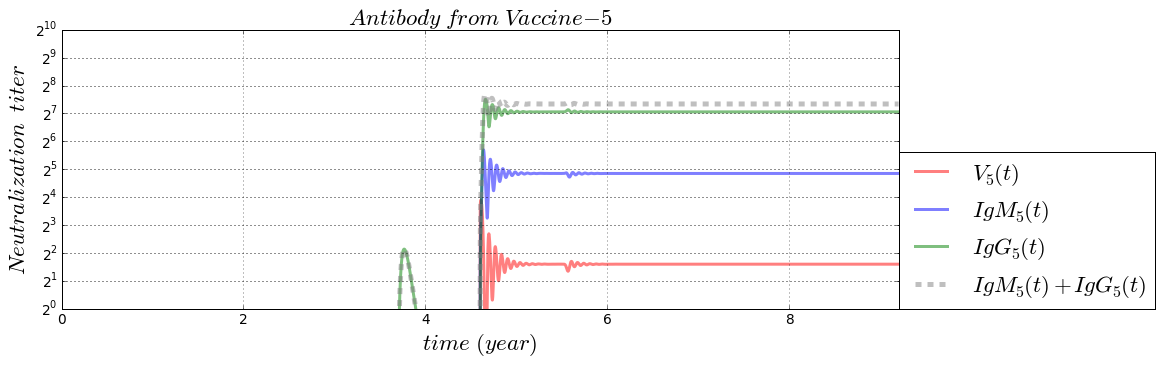

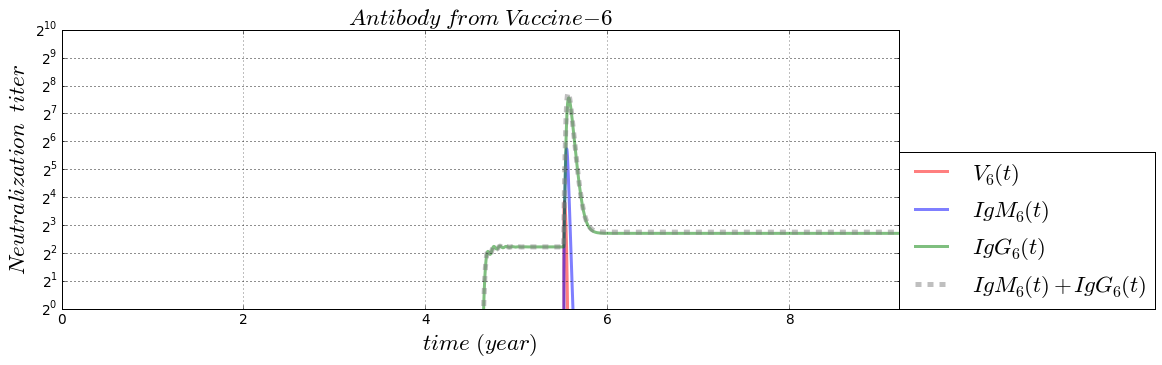

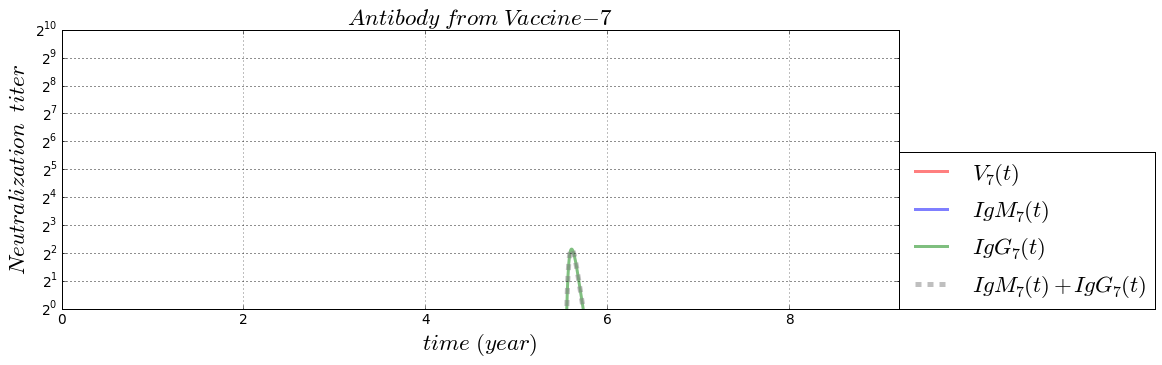

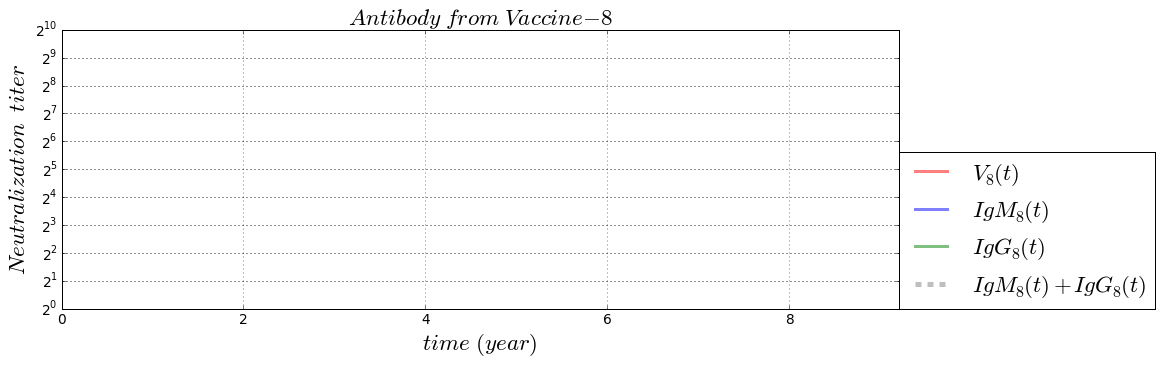

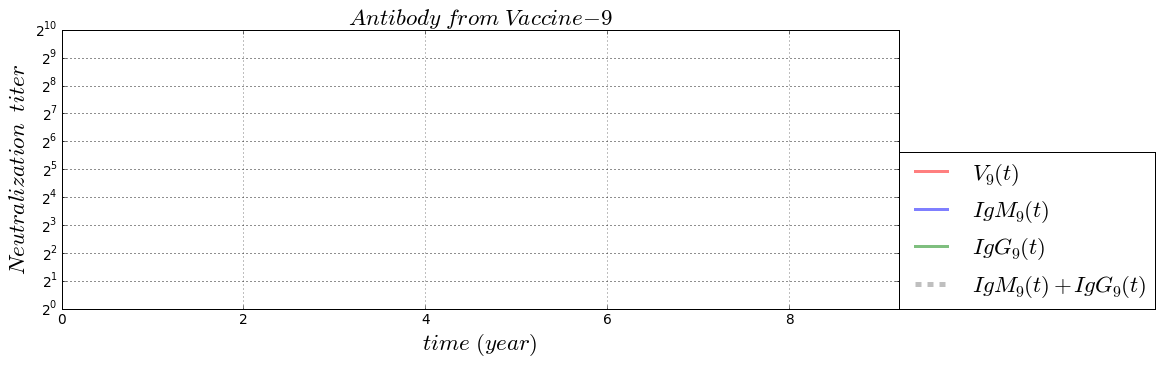

In [2]:
# setting parameter
timeUnit = 'year'
if timeUnit == 'hour':
    hour = float(1)
    day = float(24)
elif timeUnit == 'day':
    day = float(1)
    hour = float(1)/24 
elif timeUnit == 'year':
    year = float(1)
    day = float(1)/365
    hour = float(1)/24/365 
    
maxV = float(16) # max vaccine/micro-liter
inRateV = 0.2/hour # in-rate of virus
killRateVm = 0.001/hour # kill-rate of virus by antibody-IgM
killRateVg = killRateVm # kill-rate of virus by antibody-IgG

inRateB = 0.06/hour # in-rate of B-cell
outRateB = inRateB/8 # out-rate of B-cell
actRateBm = killRateVm # activation rate of naive B-cell
actRateBg = killRateVg # activation rate of memory B-cell for 1st-time-infection

inRateM = 0.16/hour # in-rate of antibody-IgM from naive B-cell
outRateM = inRateM/1  # out-rate of antibody-IgM from naive B-cell
consumeRateM = killRateVm # consume-rate of antibody-IgM by cleaning virus

inRateG = inRateM/6 # in-rate of antibody-IgG from memory B-cell
outRateG = outRateM/60 # out-rate of antibody-IgG from memory B-cell
consumeRateG = killRateVg  # consume-rate of antibody-IgG by cleaning virus
 
mutatRateB = 0.00009/hour # Virus mutation rate
mutatRateA = 0.0001/hour # antibody mutation rate



# time boundary and griding condition
minT = float(0)
maxT = float(10*12*28*day)
totalPoint_T = int(6*10**3 + 1)
gT = np.linspace(minT, maxT, totalPoint_T)
spacingT = np.linspace(minT, maxT, num = totalPoint_T, retstep = True)
gT = spacingT[0]
dt = spacingT[1]

# space boundary and griding condition
minX = float(0)
maxX = float(9)

totalPoint_X = int(maxX - minX + 1)
gX = np.linspace(minX, maxX, totalPoint_X)
gridingX = np.linspace(minX, maxX, num = totalPoint_X, retstep = True)
gX = gridingX[0]
dx = gridingX[1]
gV_array = np.zeros([totalPoint_X, totalPoint_T])
gB_array = np.zeros([totalPoint_X, totalPoint_T])
gM_array = np.zeros([totalPoint_X, totalPoint_T])
gG_array = np.zeros([totalPoint_X, totalPoint_T])
# initial output condition
#gV_array[1, 0] = float(2)

# [viral population, starting time] ---first
origin_virus = int(1)
current_virus = int(2)
infection_period = 12*28*day
viral_population = np.zeros(int(maxX + 1))
viral_population[origin_virus:current_virus + 1] = 0
infection_starting_time = np.arange(int(maxX + 1))*infection_period 
event_infect = np.zeros([int(maxX + 1), 2])
event_infect[:, 0] = viral_population
event_infect[:, 1] = infection_starting_time
event_infect[0, 1] = 0
print ('event_infect = {:}'.format(event_infect)) 

# [viral population, starting time] ---repeated
viral_population = np.zeros(int(maxX + 1))
viral_population[origin_virus:current_virus + 1] = 0
infection_starting_time = np.arange(int(maxX + 1))*0
event_repeated = np.zeros([int(maxX + 1), 2])
event_repeated[:, 0] = viral_population
event_repeated[:, 1] = infection_starting_time
print ('event_repeated = {:}'.format(event_repeated)) 

# [vaccine population, starting time] ---first
origin_vaccine = int(2)
current_vaccine = int(6)
vaccine_period = 12*28*day
vaccine_population = np.zeros(int(maxX + 1))
vaccine_population[origin_vaccine:current_vaccine + 1] = 8
vaccine_starting_time = np.arange(int(maxX + 1))*vaccine_period 
event_vaccine = np.zeros([int(maxX + 1), 2])
event_vaccine[:, 0] = vaccine_population
event_vaccine[:, 1] = vaccine_starting_time
event_vaccine[0, 1] = 0
print ('event_vaccine = {:}'.format(event_vaccine)) 

#[origin-virus, current-virus, recovered-day, repeated-parameter, OAS+, OSA-]
min_cell = 0.01 # minimum cell
recovered_time = 14*day # recovered time of 1st-time infection 
actRateBg_recovered = actRateBg*9 # activation rate of memory B-cell for repeated-infection (same virus)
inRateG_OAS_boost = 4/hour # boosting in-rate of antibody-IgG from memory B-cell for origin-virus
actRateBg_OAS_press = -0.0004/hour # depress act-rate from memory B-cell for non-origin-virus
event_infection_parameter = np.array([origin_virus,
                                      current_virus, 
                                      min_cell, 
                                      recovered_time,
                                      actRateBg_recovered,
                                      inRateG_OAS_boost,
                                      actRateBg_OAS_press,
                                      0.0])
# vaccination_parameter
# vaccination_parameter
# vaccination_parameter
min_cell_v = 0.2 # minimum cell
recovered_time_v = 14*day # recovered time of 1st-time infection 
actRateBg_recovered_v = actRateBg*9 # activation rate of memory B-cell for repeated-infection (same virus)
inRateG_OAS_boost_v = 1.5/hour # boosting in-rate of antibody-IgG from memory B-cell for origin-virus
actRateBg_OAS_press_v = -0.001/hour # depress act-rate from memory B-cell for non-origin-virus
outRateB_OAS_slow_v = -outRateB/1.4
event_vaccination_parameter = np.array([origin_vaccine,
                                        current_vaccine, 
                                        min_cell_v, 
                                        recovered_time_v,
                                        actRateBg_recovered_v,
                                        inRateG_OAS_boost_v,
                                        actRateBg_OAS_press_v,
                                        outRateB_OAS_slow_v])

event_parameter = np.array([event_infection_parameter, event_vaccination_parameter])

event_table = np.array([event_parameter, event_infect, event_repeated, event_vaccine])

# Runge Kutta numerical solution
pde_array = np.array([dVdt_array, dBdt_array, dMdt_array, dGdt_array])
initial_Out = np.array([gV_array, gB_array, gM_array, gG_array])
gOut_array = alva.AlvaRungeKutta4XT(pde_array, initial_Out, minX, maxX, totalPoint_X, minT, maxT, totalPoint_T, event_table)

# plotting
gV = gOut_array[0]  
gB = gOut_array[1] 
gM = gOut_array[2]
gG = gOut_array[3]

numberingFig = numberingFig + 1
for i in range(totalPoint_X):
    figure_name = '-response-%i'%(i)
    figure_suffix = '.png'
    save_figure = os.path.join(dir_path, file_name + figure_name + file_suffix)
    plt.figure(numberingFig, figsize = AlvaFigSize)
    plt.plot(gT, gV[i], color = 'red', label = r'$ V_{%i}(t) $'%(i), linewidth = 3.0, alpha = 0.5)
    plt.plot(gT, gM[i], color = 'blue', label = r'$ IgM_{%i}(t) $'%(i), linewidth = 3.0, alpha = 0.5)
    plt.plot(gT, gG[i], color = 'green', label = r'$ IgG_{%i}(t) $'%(i), linewidth = 3.0, alpha = 0.5)
    plt.plot(gT, gM[i] + gG[i], color = 'gray', linewidth = 5.0, alpha = 0.5, linestyle = 'dashed'
             , label = r'$ IgM_{%i}(t) + IgG_{%i}(t) $'%(i, i))
    plt.grid(True, which = 'both')
    plt.title(r'$ Antibody \ from \ Vaccine-{%i} $'%(i), fontsize = AlvaFontSize)
    plt.xlabel(r'$time \ (%s)$'%(timeUnit), fontsize = AlvaFontSize)
    plt.ylabel(r'$ Neutralization \ \ titer $', fontsize = AlvaFontSize)
    plt.xlim([minT, maxT])
    plt.xticks(fontsize = AlvaFontSize*0.6)
    plt.yticks(fontsize = AlvaFontSize*0.6) 
    plt.ylim([2**0, 2**10])
    plt.yscale('log', basey = 2)
    plt.legend(loc = (1,0), fontsize = AlvaFontSize)
    plt.savefig(save_figure, dpi = 100, bbox_inches='tight')
    plt.show()

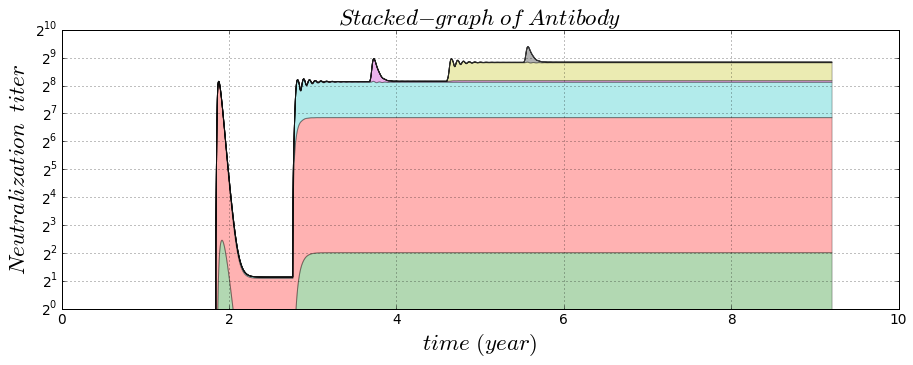

In [3]:
# Normalization stacked graph
numberingFig = numberingFig + 1
plt.figure(numberingFig, figsize = AlvaFigSize)
plt.stackplot(gT, gM + gG, alpha = 0.3)
plt.title(r'$ Stacked-graph \ of \ Antibody $', fontsize = AlvaFontSize)
plt.xlabel(r'$time \ (%s)$'%(timeUnit), fontsize = AlvaFontSize)
plt.ylabel(r'$ Neutralization \ \ titer $', fontsize = AlvaFontSize)
plt.xticks(fontsize = AlvaFontSize*0.6)
plt.yticks(fontsize = AlvaFontSize*0.6) 
plt.ylim([2**0, 2**10])
plt.yscale('log', basey = 2)
plt.grid(True)
plt.show()

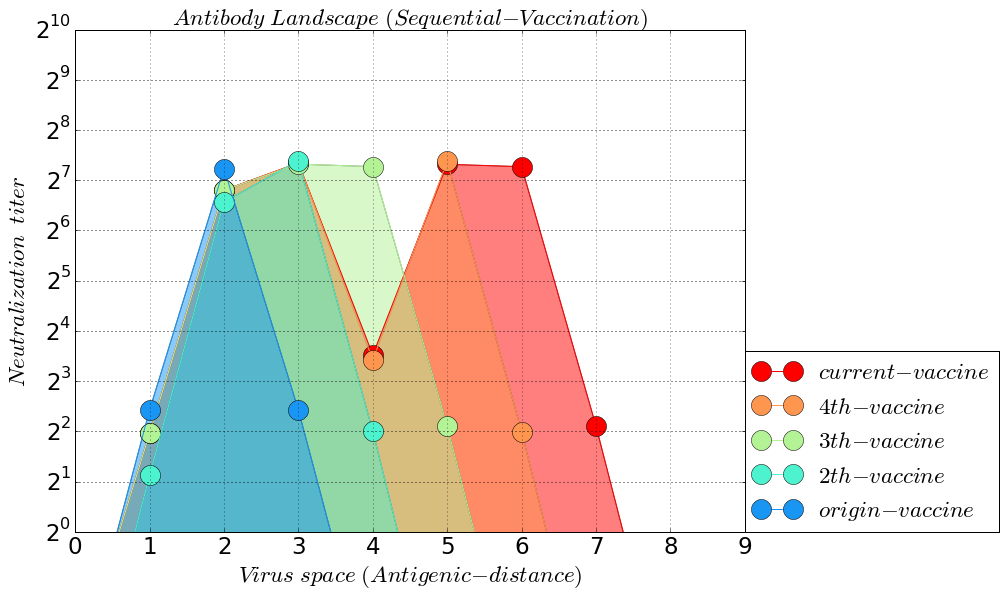

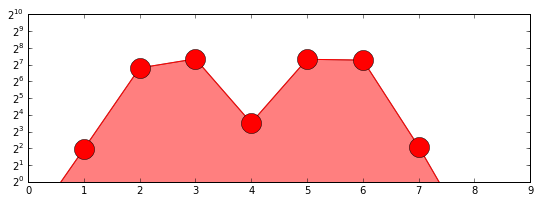

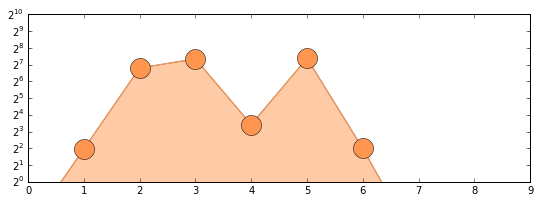

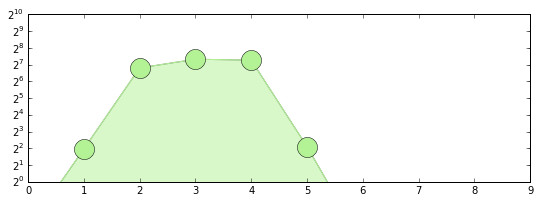

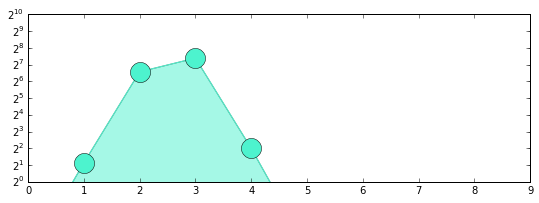

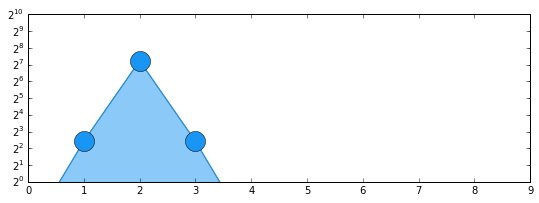

In [4]:
# expected peak of the antibody response
totalColor = current_vaccine - origin_vaccine + 1 
AlvaColor = [plt.get_cmap('rainbow')(float(i)/(totalColor)) for i in range(1, totalColor + 1)]

sample_time = 28*day
# plotting
figure_name = '-landscape'
file_suffix = '.png'
save_figure = os.path.join(dir_path, file_name + figure_name + file_suffix)

numberingFig = numberingFig + 1
plt.figure(numberingFig, figsize = (12, 9))
for i in range(origin_vaccine, current_vaccine + 1):
    detect_xn = current_vaccine + 2 - i
    if detect_xn == origin_vaccine:
        vaccine_label = '$ origin-vaccine $'
    elif detect_xn == current_vaccine:
        vaccine_label = '$ current-vaccine $' 
    else: vaccine_label = '$ {:}th-vaccine $'.format(detect_xn - origin_vaccine + 1)
    detect_time = int(totalPoint_T/(maxT - minT)*(detect_xn*vaccine_period + sample_time))
    plt.plot(gX, gM[:, detect_time] + gG[:, detect_time], marker = 'o', markersize = 20
             , color = AlvaColor[detect_xn - origin_vaccine], label = vaccine_label)
    plt.fill_between(gX, gM[:, detect_time] + gG[:, detect_time], facecolor = AlvaColor[detect_xn - origin_vaccine]
                     , alpha = 0.5)
    
plt.grid(True, which = 'both')
plt.title(r'$ Antibody \ Landscape \ (Sequential-Vaccination) $', fontsize = AlvaFontSize)
plt.xlabel(r'$ Virus \ space \ (Antigenic-distance) $', fontsize = AlvaFontSize)
plt.ylabel(r'$ Neutralization \ \ titer $', fontsize = AlvaFontSize)
plt.xlim([minX, maxX])
plt.xticks(fontsize = AlvaFontSize)
plt.yticks(fontsize = AlvaFontSize) 
plt.ylim([2**0, 2**10])
plt.yscale('log', basey = 2)
plt.legend(loc = (1,0), fontsize = AlvaFontSize)
plt.savefig(save_figure, dpi = 100, bbox_inches='tight')
plt.show()

# each frame
numberingFig = numberingFig + 1
for i in range(origin_vaccine, current_vaccine + 1):
    plt.figure(numberingFig, figsize = (9,3))
    detect_xn = current_vaccine + 2 - i
    if detect_xn == origin_vaccine:
        vaccine_label = '$ origin-vaccine $'
    elif detect_xn == current_vaccine:
        vaccine_label = '$ current-vaccine $' 
    else: vaccine_label = '$ {:}th-vaccine $'.format(detect_xn - origin_vaccine + 1)
    detect_time = int(totalPoint_T/(maxT - minT)*(detect_xn*vaccine_period + sample_time))
    plt.plot(gX, gM[:, detect_time] + gG[:, detect_time], marker = 'o', markersize = 20
             , color = AlvaColor[detect_xn - origin_vaccine], label = vaccine_label)
    plt.fill_between(gX, gM[:, detect_time] + gG[:, detect_time], facecolor = AlvaColor[detect_xn - origin_vaccine]
                     , alpha = 0.5)
    plt.ylim([2**0, 2**10])
    plt.yscale('log', basey = 2)
    plt.show()